In [275]:
using Revise
using PastaQ
using ITensors
using Random
using OptimKit
using Zygote
using Zygote: ChainRulesCore
using BenchmarkTools
using LinearAlgebra
using JLD2
using Flux
using PyCall
using SymPy
using QOS
using Plots
using Pickle

import mVQE
using mVQE.Hamiltonians: hamiltonian_tfi, hamiltonian_ghz, hamiltonian_aklt_half
using mVQE.ITensorsExtension: projective_measurement
using mVQE: loss, optimize_and_evolve
using mVQE.Circuits: AbstractVariationalCircuit, VariationalCircuitRy, VariationalMeasurement, VariationalMeasurementMC, VariationalMeasurementMCFeedback
using mVQE.Misc: get_ancillas_indices, pprint
using mVQE.Optimizers: OptimizerWrapper
using mVQE.pyflexmps: pfs

In [56]:
N_state = 4 * 5
state_indices, ancilla_indices, N = get_ancillas_indices(N_state, [false, true, true, true, true, false])
hilbert = qubits(N)

hilbert_state = hilbert[state_indices]
hilbert_ancilla = hilbert[ancilla_indices]

ψ = productstate(hilbert, fill(0, N))
aklts = mVQE.StateFactory.AKLT_halfs(hilbert[state_indices], basis="girvin");
state_indices, ancilla_indices, N

([2, 3, 4, 5, 8, 9, 10, 11, 14, 15, 16, 17, 20, 21, 22, 23, 26, 27, 28, 29], [1, 6, 7, 12, 13, 18, 19, 24, 25, 30], 30)

In [57]:
aklts = mVQE.StateFactory.AKLT_halfs(hilbert[state_indices], basis="girvin")
H, = hamiltonian_aklt_half(hilbert_state)
Htot, Htot_aklt, Htot_spin1 = hamiltonian_aklt_half(hilbert, sublattice=state_indices);

In [58]:
vmodels = [mVQE.GirvinProtocol.GirvinCircuitIdeal(N_state), mVQE.GirvinProtocol.GirvinCorrCircuit(Int(N_state/2))]

g(a, b)= mVQE.GirvinProtocol.param_correction_gates
    
model = VariationalMeasurementMCFeedback(vmodels, [g], ancilla_indices);

In [87]:
ψ_aklt = model(ψ);
inner(ψ_aklt, Htot, ψ_aklt')

-3.580583517969505e-15 + 1.2335727721302827e-16im

In [235]:
ϵ = 1e-3
p = 1 - exp(-pi/2 * ϵ)
noise = (1 => ("depolarizing", (p = p,)), 
         2 => ("depolarizing", (p = p,)))

noise2 =("dephasing", (γ = p,))

("dephasing", (γ = 0.0015695632719552322,))

In [236]:
ρ_aklt = model(ψ; noise=noise)
fid = sum([inner(aklt, ρ_aklt_tr, aklt') for aklt in aklts])

real(inner(ρ_aklt, Htot)), real(fid)

(0.1532967001485526, 0.566727040072944)

In [237]:
using Suppressor

In [238]:
@suppress_err ρ_aklt = model(ψ; noise=noise2)
ρ_aklt_tr = tr(ρ_aklt, ancilla_indices)
fid = sum([inner(aklt, ρ_aklt_tr, aklt') for aklt in aklts])

real(inner(ρ_aklt, Htot)), real(fid)

(0.05049850987327341, 0.9408074029478039)

In [304]:
function fid_noise(ϵ)
    p = 1 - exp(-pi/2 * ϵ/6)
    noise = ("dephasing", (γ = p,))
    ρ_aklt = @suppress_err model(ψ; noise=noise)
    ρ_aklt_tr = tr(ρ_aklt, ancilla_indices)
    fid = sum([inner(aklt, ρ_aklt_tr, aklt') for aklt in aklts])

    return 1-real(fid), real(inner(ρ_aklt, Htot)) / (N_state/2 - 1)
end

fid_noise (generic function with 1 method)

In [279]:
fid_noise(0.0001)

(0.9940303328814682, 0.004955703888423341)

In [305]:
@time begin
ϵs = 10 .^ LinRange(-4, -1, 100)
f = [collect(fid_noise(ϵ)) for ϵ in ϵs]
f = hcat(f...)
end;

 11.175004 seconds (40.79 M allocations: 11.477 GiB, 12.15% gc time, 1.66% compilation time)


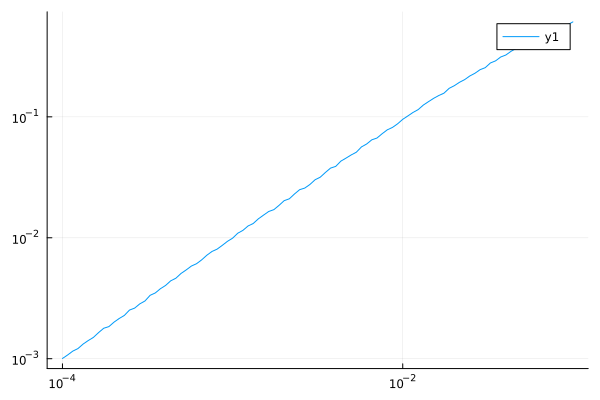

In [306]:
plot(ϵs, f[1, :], xscale=:log10, yscale=:log10)

In [307]:
Pickle.store("./girvin_fid.pkl", [ϵs, f[1, :], f[2, :]])